In [1]:
import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/stocknews/upload_DJIA_table.csv
/kaggle/input/stocknews/Combined_News_DJIA.csv
/kaggle/input/stocknews/RedditNews.csv


In [2]:
import re
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from random import randint
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
df = pd.read_csv('/kaggle/input/stocknews/Combined_News_DJIA.csv', encoding = 'ISO-8859-1')
df.dropna(inplace=True)
print(df.shape)
df.head(2)

(1986, 27)


,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",...,b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge"""
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo..."


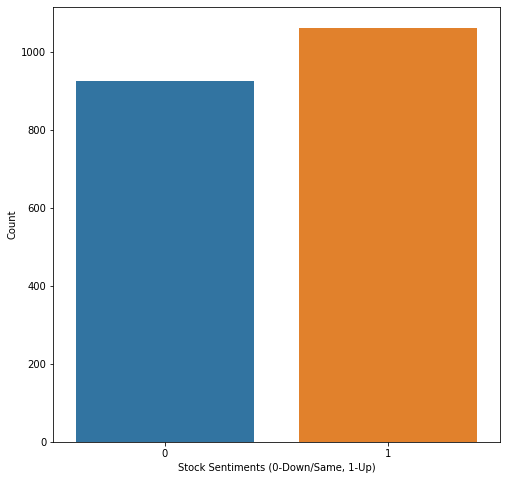

In [4]:
plt.figure(figsize=(8,8))
sns.countplot(x='Label', data=df)
plt.xlabel('Stock Sentiments (0-Down/Same, 1-Up)')
plt.ylabel('Count')
plt.show()

In [5]:
df_copy = df.copy()
df_copy.reset_index(inplace=True)
train = df_copy[df_copy['Date'] < '20150101']
test = df_copy[df_copy['Date'] > '20141231']
y_train = train['Label']
train = train.iloc[:, 3:28]
y_test = test['Label']
test = test.iloc[:, 3:28]

In [6]:
train.replace(to_replace='[^a-zA-Z]', value=' ', regex=True, inplace=True)
test.replace(to_replace='[^a-zA-Z]', value=' ', regex=True, inplace=True)

In [7]:
new_columns = [str(i) for i in range(0,25)]
train.columns = new_columns
test.columns = new_columns
for i in new_columns:
  train[i] = train[i].str.lower()
  test[i] = test[i].str.lower()

In [8]:
train_headlines = []
test_headlines = []
for row in range(0, train.shape[0]):
  train_headlines.append(' '.join(str(x) for x in train.iloc[row, 0:25]))
for row in range(0, test.shape[0]):
  test_headlines.append(' '.join(str(x) for x in test.iloc[row, 0:25]))

In [9]:
ps = PorterStemmer()
train_corpus = []
for i in range(0, len(train_headlines)):
  words = train_headlines[i].split()
  words = [word for word in words if word not in set(stopwords.words('english'))]
  words = [ps.stem(word) for word in words]
  headline = ' '.join(words)
  train_corpus.append(headline)

In [10]:
test_corpus = []
for i in range(0, len(test_headlines)):
  words = test_headlines[i].split()
  words = [word for word in words if word not in set(stopwords.words('english'))]
  words = [ps.stem(word) for word in words]
  headline = ' '.join(words)
  test_corpus.append(headline)

In [11]:
down_words = []
for i in list(y_train[y_train==0].index):
  down_words.append(train_corpus[i])
up_words = []
for i in list(y_train[y_train==1].index):
  up_words.append(train_corpus[i])

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=10000, ngram_range=(2,2))
X_train = cv.fit_transform(train_corpus).toarray()
X_test = cv.transform(test_corpus).toarray()

In [15]:
from sklearn.linear_model import LogisticRegression
lr_classifier = LogisticRegression()
lr_classifier.fit(X_train, y_train)
lr_y_pred = lr_classifier.predict(X_test)

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
score1 = accuracy_score(y_test, lr_y_pred)
score2 = precision_score(y_test, lr_y_pred)
score3 = recall_score(y_test, lr_y_pred)
print("Accuracy score is: {}%".format(round(score1*100,2)))
print("Precision score is: {}".format(round(score2,2)))
print("Recall score is: {}".format(round(score3,2)))

Accuracy score is: 83.07%
Precision score is: 0.83
Recall score is: 0.83


In [17]:
from sklearn.metrics import confusion_matrix
lr_cm = confusion_matrix(y_test, lr_y_pred)
lr_cm

array([[154,  32],
       [ 32, 160]])

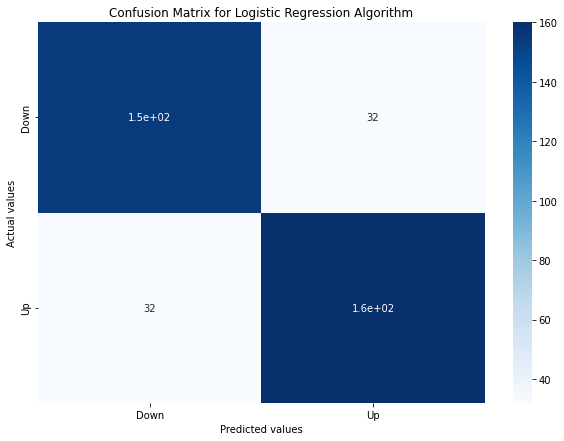

In [18]:
plt.figure(figsize=(10,7))
sns.heatmap(data=lr_cm, annot=True, cmap="Blues", xticklabels=['Down', 'Up'], yticklabels=['Down', 'Up'])
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Confusion Matrix for Logistic Regression Algorithm')
plt.show()

In [19]:
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=100, criterion='entropy')
rf_classifier.fit(X_train, y_train)
rf_y_pred = rf_classifier.predict(X_test)

In [20]:
score1 = accuracy_score(y_test, rf_y_pred)
score2 = precision_score(y_test, rf_y_pred)
score3 = recall_score(y_test, rf_y_pred)
print("Accuracy score is: {}%".format(round(score1*100,2)))
print("Precision score is: {}".format(round(score2,2)))
print("Recall score is: {}".format(round(score3,2)))

Accuracy score is: 83.07%
Precision score is: 0.79
Recall score is: 0.91


In [21]:
rf_cm = confusion_matrix(y_test, rf_y_pred)
rf_cm

array([[140,  46],
       [ 18, 174]])

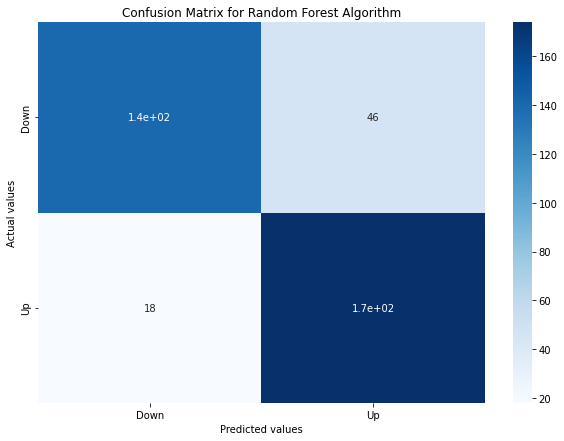

In [22]:
plt.figure(figsize=(10,7))
sns.heatmap(data=rf_cm, annot=True, cmap="Blues", xticklabels=['Down', 'Up'], yticklabels=['Down', 'Up'])
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Confusion Matrix for Random Forest Algorithm')
plt.show()

In [23]:
from sklearn.naive_bayes import MultinomialNB
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)
nb_y_pred = nb_classifier.predict(X_test)

In [24]:
score1 = accuracy_score(y_test, nb_y_pred)
score2 = precision_score(y_test, nb_y_pred)
score3 = recall_score(y_test, nb_y_pred)
print("Accuracy score is: {}%".format(round(score1*100,2)))
print("Precision score is: {}".format(round(score2,2)))
print("Recall score is: {}".format(round(score3,2)))

Accuracy score is: 84.92%
Precision score is: 0.86
Recall score is: 0.84


In [25]:
nb_cm = confusion_matrix(y_test, nb_y_pred)
nb_cm

array([[159,  27],
       [ 30, 162]])

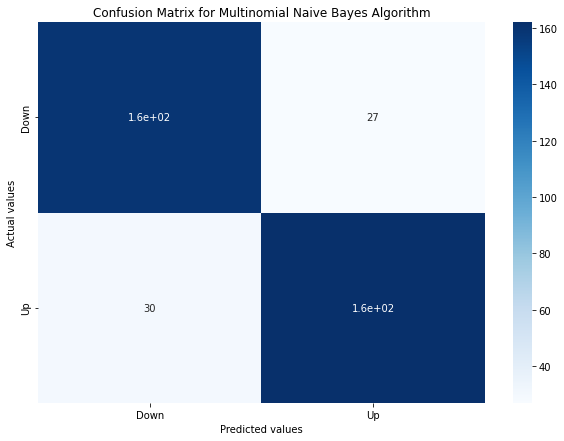

In [26]:
plt.figure(figsize=(10,7))
sns.heatmap(data=nb_cm, annot=True, cmap="Blues", xticklabels=['Down', 'Up'], yticklabels=['Down', 'Up'])
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Confusion Matrix for Multinomial Naive Bayes Algorithm')
plt.show()